#### Homework 3 
#### Eduardo Neville & Åke Janson 
#### Spring 2023

###### We import the packages to the jupyter notebook 

In [ ]:
import numpy as np
from scipy.stats import norm 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import pandas as pd

We then import the excel file and create a dataframe 

   NESN SW  ROG SW  NOVN SW  EURUSD  CHFUSD
0  21.3244   93.83    33.85  0.9517  0.6257
1  21.4767   93.97    35.05  0.9280  0.6129
2  20.3090   91.76    33.79  0.9495  0.6236
3  19.9987   91.19    32.32  0.9570  0.6258
4  20.3090   91.59    31.56  0.9467  0.6213


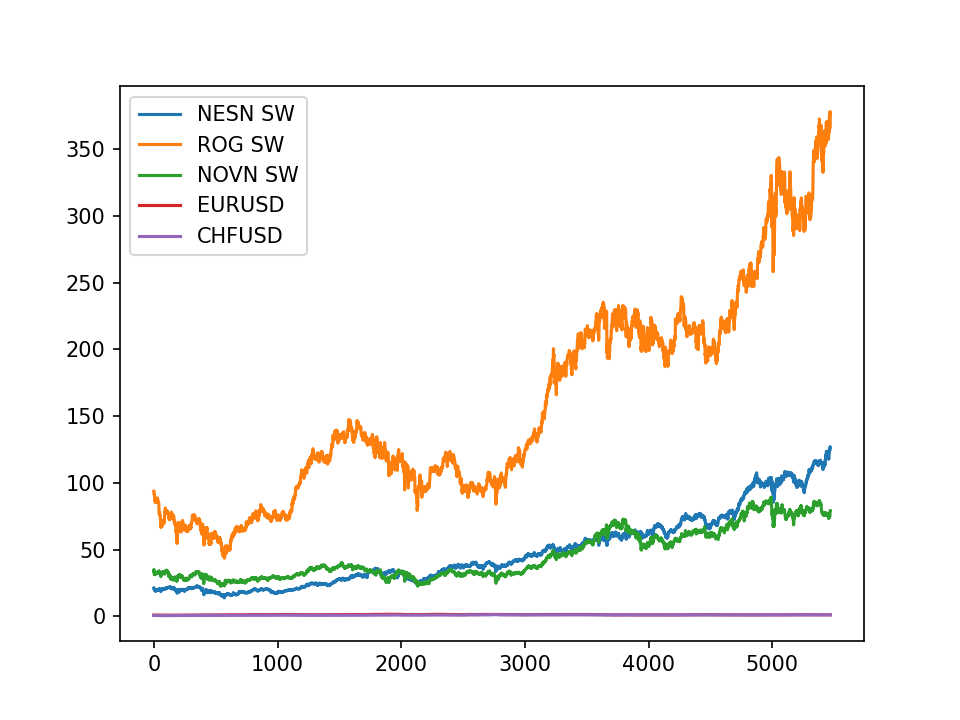

In [1]:
#read the excel file
data = pd.read_excel(r'data.xlsx') 
df = pd.DataFrame(data, columns = ['NESN SW', 'ROG SW', 'NOVN SW', 'EURUSD', 'CHFUSD'])
print(df.head())
# show the growth of the assets
plt.plot(df)
plt.legend(df.columns)

We then print the daily simple returns of each asset

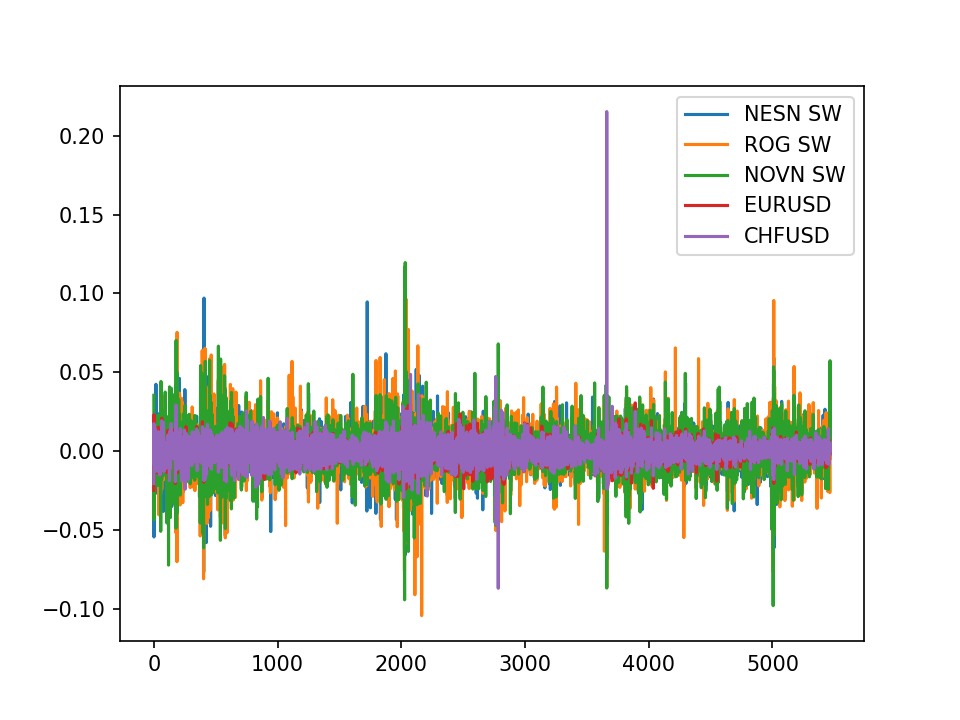

In [2]:
#calculate the daily simple returns
def percentage_change(df):
    returns = df.apply(lambda x: x.pct_change(1).dropna().reset_index(drop=True)) 
    return returns

#apply the function to the dataframe
plt.plot(percentage_change(df))
plt.legend(df.columns)
plt.show()

In [ ]:
#calculate VaR and ES given the historical simulation method
def getVaR_ES(alpha, sorted_returns):
    index = int(np.ceil(alpha*(len(sorted_returns))))
    VaR = sorted_returns.apply(lambda x: -x[index])
    ES = sorted_returns.apply(lambda x: -x[:index].mean())
    return VaR, ES

In [ ]:
#calculate returns, sort them, and calculate the VaR and ES (historical simulation method)
def var_esHist(alpha, df): 
    returns = percentage_change(df) 
    sorted_returns = returns.apply(lambda x: x.sort_values().reset_index(drop=True)) 
    return getVaR_ES(alpha, sorted_returns)

In [3]:
var_esHist(0.1,df), var_esHist(0.01,df), var_esHist(0.001,df)

((NESN SW    0.011707
  ROG SW     0.014220
  NOVN SW    0.013137
  EURUSD     0.006887
  CHFUSD     0.006993
  dtype: float64,
  NESN SW    0.020079
  ROG SW     0.024271
  NOVN SW    0.022133
  EURUSD     0.010519
  CHFUSD     0.011012
  dtype: float64),
 (NESN SW    0.031429
  ROG SW     0.037515
  NOVN SW    0.033238
  EURUSD     0.015343
  CHFUSD     0.015729
  dtype: float64,
  NESN SW    0.043163
  ROG SW     0.051699
  NOVN SW    0.047333
  EURUSD     0.018491
  CHFUSD     0.021021
  dtype: float64),
 (NESN SW    0.061237
  ROG SW     0.070041
  NOVN SW    0.061766
  EURUSD     0.021107
  CHFUSD     0.024128
  dtype: float64,
  NESN SW    0.066953
  ROG SW     0.085775
  NOVN SW    0.080138
  EURUSD     0.023852
  CHFUSD     0.040402
  dtype: float64))

In [ ]:
#analytical computation of Value at Risk for a normally distributed random variable
def varNorm(mu, sigma, alpha):
    quantile = norm.ppf(alpha)
    return -mu - sigma*quantile

In [ ]:
#analytical computation of Expected Shortfall for a normally distributed random variable
def esNorm(mu, sigma, alpha):
    quantile = norm.ppf(alpha)
    return -mu + sigma/alpha*norm.pdf(quantile)

# Monte Carlo Simulation

In [ ]:
#Monte Carlo simulation method: Value at Risk for a normally distributed random variable
def varNormMC(mu, sigma, alpha, numSim):
    simulatedSample = np.random.normal(loc=mu, scale=sigma, size=numSim)
    return -np.quantile(simulatedSample, alpha)

In [ ]:
#Monte Carlo simulation method: Expected Shortfall for a normally distributed random variable
def esNormMC(mu, sigma, alpha, numSim):
    simulatedSample = np.random.normal(loc=mu, scale=sigma, size=numSim)
    sortedSample = np.sort(simulatedSample)
    index = int(np.ceil(numSim*alpha))
    return -np.average(sortedSample[0:index])

In [4]:
mu, sigma, alpha = 0.04, 0.15, 0.01
varNorm(mu, sigma, alpha), esNorm(mu, sigma, alpha)

(0.3089521811061261, 0.35978213305187123)

In [5]:
numSim = 1000
varNormMC(mu, sigma, alpha, numSim), esNormMC(mu, sigma, alpha, numSim)

(0.3121232766553916, 0.3399926887155169)

In [ ]:
#bootstrapped distribution of MC computed Value at Risk and Expected Shortfall for a Gaussian random variable
def bootstrapNormVaRES(mu, sigma, alpha, numSim, numBootstraps, numBins):
    varDistribution = np.empty(numBootstraps)
    esDistribution = np.empty(numBootstraps)
    for i in range(numBootstraps):
        varDistribution[i] = varNormMC(mu, sigma, alpha, numSim)
        esDistribution[i] = esNormMC(mu, sigma, alpha, numSim)
    plt.hist(varDistribution, numBins)
    plt.legend(['VaR'])
    plt.title("Value at Risk distribution with alpha {} and {} simulations".format(alpha, numSim))
    plt.show()
    plt.hist(esDistribution, numBins)
    plt.legend(['ES'])
    plt.title("Expected Shortfall distribution with alpha {} and {} simulations".format(alpha, numSim))
    plt.show()

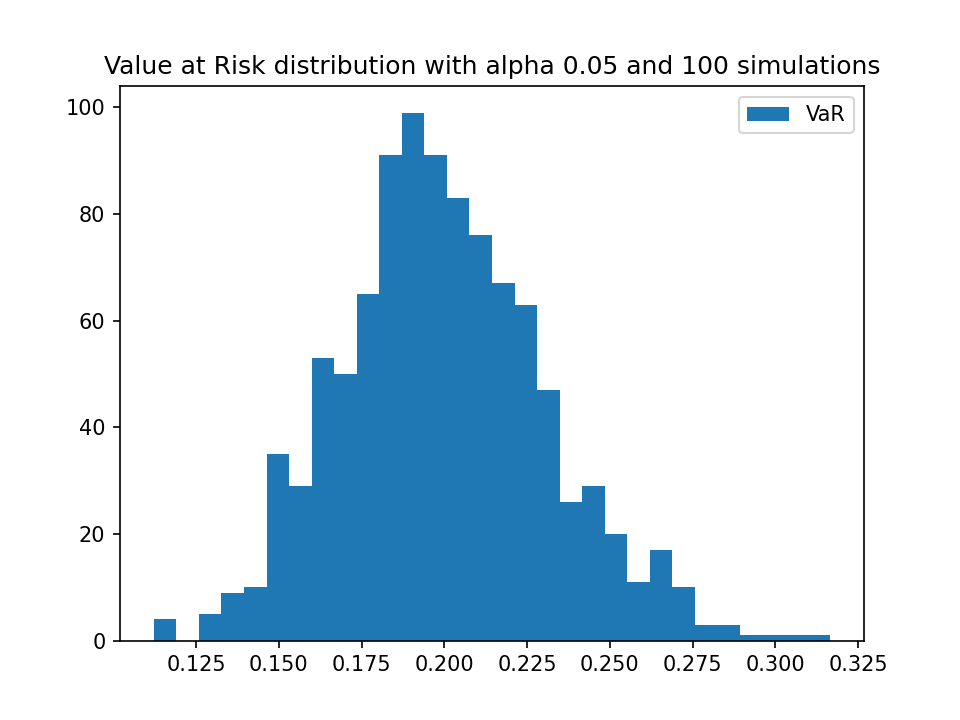

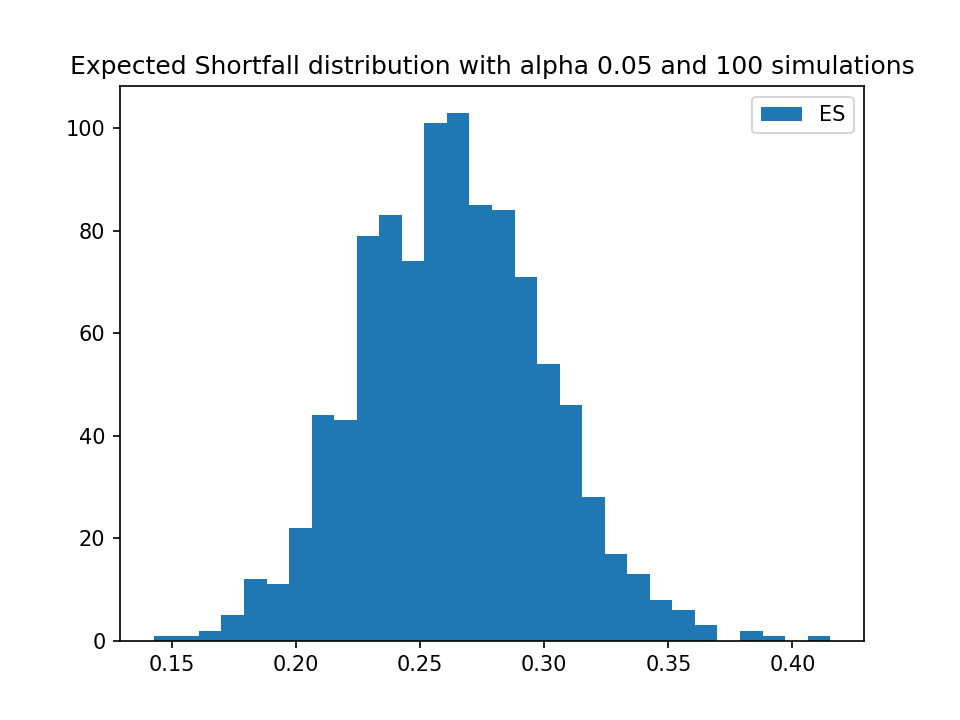

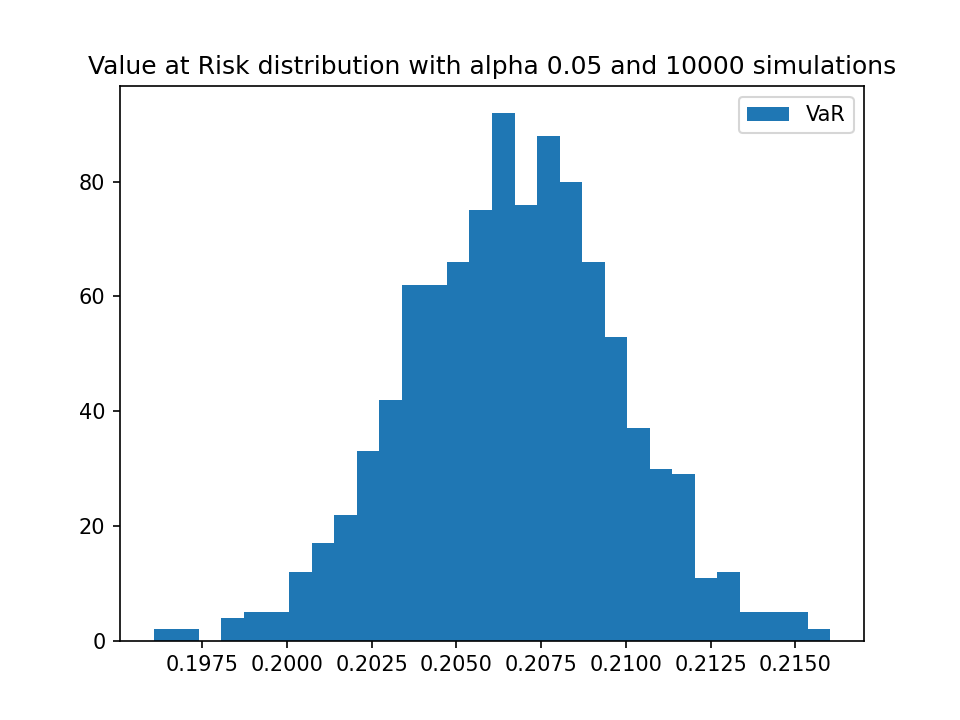

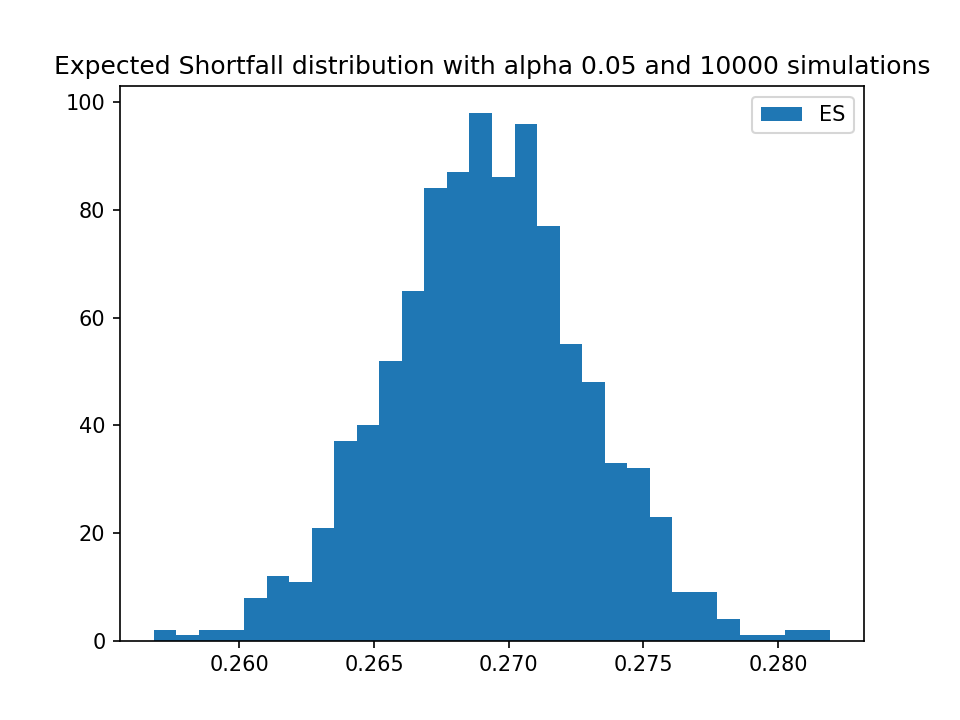

In [6]:
numSim = 100
numBootstraps = 1000
numBins = 30
alpha = 0.05
bootstrapNormVaRES(mu, sigma, alpha, numSim, numBootstraps, numBins)
numSim = 10000
bootstrapNormVaRES(mu, sigma, alpha, numSim, numBootstraps, numBins)

In [ ]:
#calculate returns, fit a univariate normal distribution, and calculate VaR and ES given the variance-covariance method under Gaussianity
def var_esVarCovNorm(alpha, df): 
    returns = percentage_change(df) 
    moments = returns.apply(lambda x: norm.fit(x)) 
    return moments.apply(lambda x: varNorm(x[0], x[1], alpha)), moments.apply(lambda x: esNorm(x[0], x[1], alpha)) 

In [7]:
var_esVarCovNorm(0.1, df), var_esVarCovNorm(0.01, df), var_esVarCovNorm(0.001, df) 

((NESN SW    0.014139
  ROG SW     0.017213
  NOVN SW    0.015856
  EURUSD     0.007419
  CHFUSD     0.008751
  dtype: float64,
  NESN SW    0.019507
  ROG SW     0.023700
  NOVN SW    0.021800
  EURUSD     0.010177
  CHFUSD     0.012030
  dtype: float64),
 (NESN SW    0.025984
  ROG SW     0.031529
  NOVN SW    0.028974
  EURUSD     0.013507
  CHFUSD     0.015987
  dtype: float64,
  NESN SW    0.029826
  ROG SW     0.036173
  NOVN SW    0.033228
  EURUSD     0.015481
  CHFUSD     0.018334
  dtype: float64),
 (NESN SW    0.034645
  ROG SW     0.041997
  NOVN SW    0.038564
  EURUSD     0.017958
  CHFUSD     0.021277
  dtype: float64,
  NESN SW    0.037784
  ROG SW     0.045791
  NOVN SW    0.042040
  EURUSD     0.019571
  CHFUSD     0.023194
  dtype: float64))

In [8]:
#difference between the historical simulation and the variance-covariance (Gaussian-based) estimation
print(var_esHist(0.1,df)[0]-var_esVarCovNorm(0.1, df)[0])
print(var_esHist(0.1,df)[1]-var_esVarCovNorm(0.1, df)[1])
print(var_esHist(0.01,df)[0]-var_esVarCovNorm(0.01, df)[0]) 
print(var_esHist(0.01,df)[1]-var_esVarCovNorm(0.01, df)[1])
print(var_esHist(0.001,df)[0]-var_esVarCovNorm(0.001, df)[0])
print(var_esHist(0.001,df)[1]-var_esVarCovNorm(0.001, df)[1])

NESN SW   -0.002432
ROG SW    -0.002993
NOVN SW   -0.002719
EURUSD    -0.000532
CHFUSD    -0.001758
dtype: float64
NESN SW    0.000572
ROG SW     0.000571
NOVN SW    0.000333
EURUSD     0.000342
CHFUSD    -0.001017
dtype: float64
NESN SW    0.005444
ROG SW     0.005986
NOVN SW    0.004265
EURUSD     0.001836
CHFUSD    -0.000258
dtype: float64
NESN SW    0.013337
ROG SW     0.015526
NOVN SW    0.014105
EURUSD     0.003010
CHFUSD     0.002688
dtype: float64
NESN SW    0.026592
ROG SW     0.028044
NOVN SW    0.023201
EURUSD     0.003150
CHFUSD     0.002851
dtype: float64
NESN SW    0.029169
ROG SW     0.039985
NOVN SW    0.038098
EURUSD     0.004281
CHFUSD     0.017207
dtype: float64
